Setting up AI model...
Using device: cpu
Model 'wkcn/TinyCLIP-ViT-39M-16-Text-19M-YFCC15M' loaded and ready.
Pre-computing text embeddings for all prompts...
Text embeddings are ready.
✅ Success! Camera found at the last known IP: 192.168.68.102
Processing at ~2 FPS. Scoring crops on motion...

--- Image being scored ---


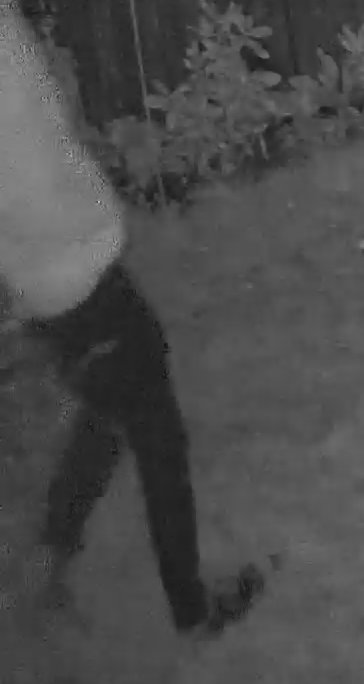

Fox: 0.015, People Sum: 0.145
New high fox score: 0.015

--- Image being scored ---


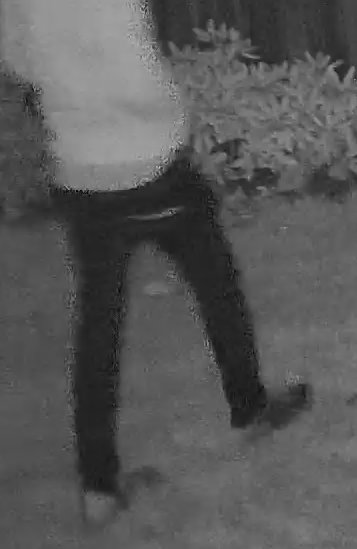

Fox: 0.005, People Sum: 0.228

--- Image being scored ---


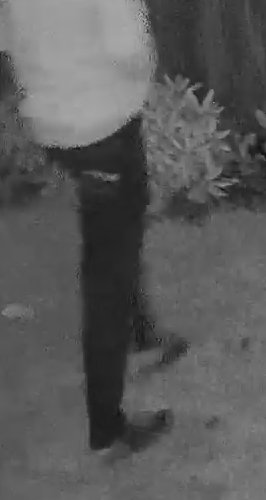

Fox: 0.020, People Sum: 0.216
New high fox score: 0.020

--- Image being scored ---


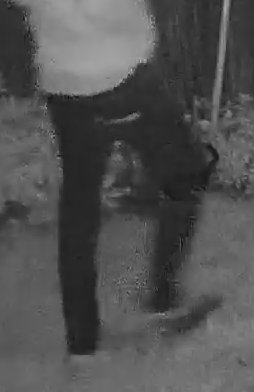

Fox: 0.015, People Sum: 0.255

--- Image being scored ---


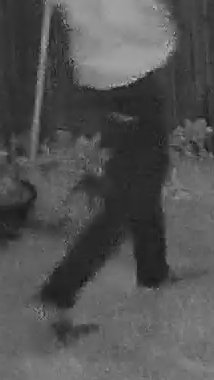

Fox: 0.005, People Sum: 0.143

--- Image being scored ---


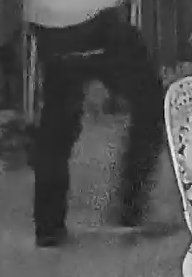

Fox: 0.018, People Sum: 0.186

--- Image being scored ---


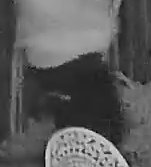

Fox: 0.004, People Sum: 0.059

--- Image being scored ---


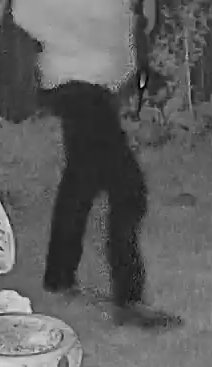

Fox: 0.013, People Sum: 0.337

--- Image being scored ---


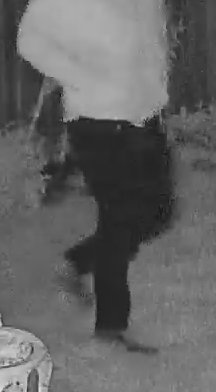

Fox: 0.003, People Sum: 0.218

--- Image being scored ---


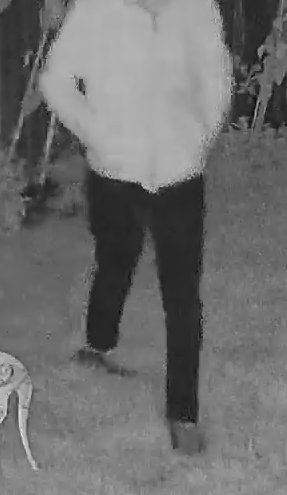

Fox: 0.024, People Sum: 0.405
New high fox score: 0.024

--- Image being scored ---


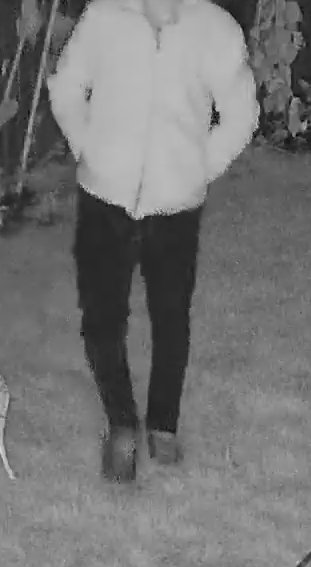

Fox: 0.006, People Sum: 0.604

--- Image being scored ---


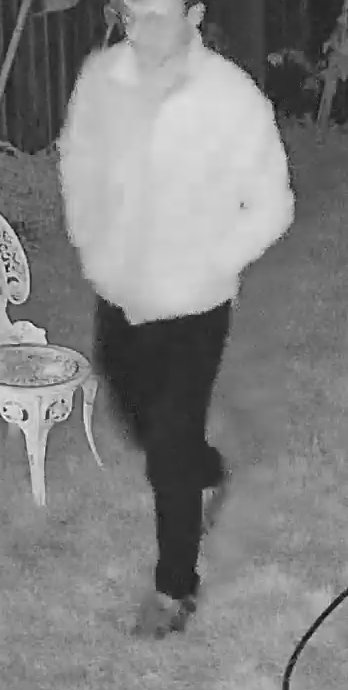

Fox: 0.058, People Sum: 0.297
New high fox score: 0.058

--- Image being scored ---


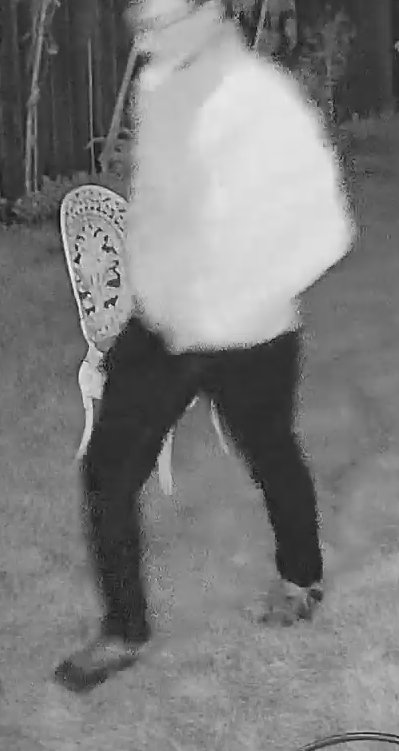

Fox: 0.015, People Sum: 0.451

--- Image being scored ---


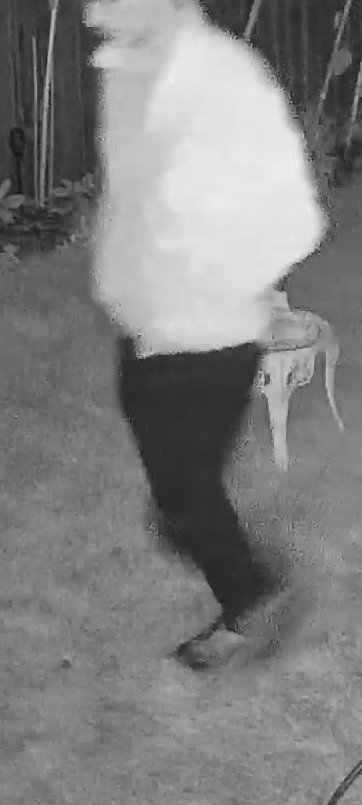

Fox: 0.066, People Sum: 0.119
New high fox score: 0.066

--- Image being scored ---


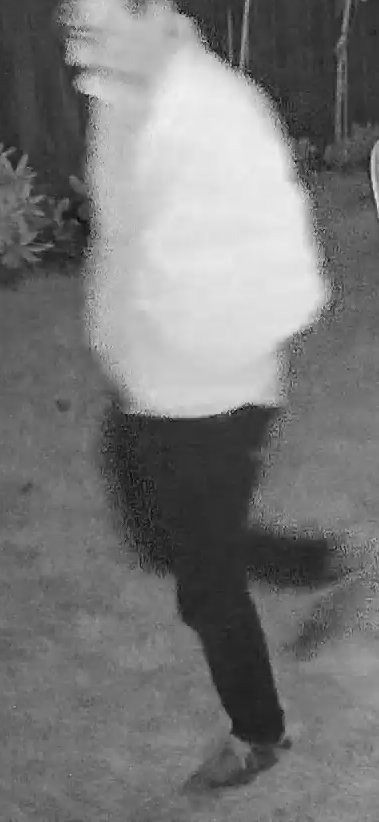

Fox: 0.006, People Sum: 0.103

--- Image being scored ---


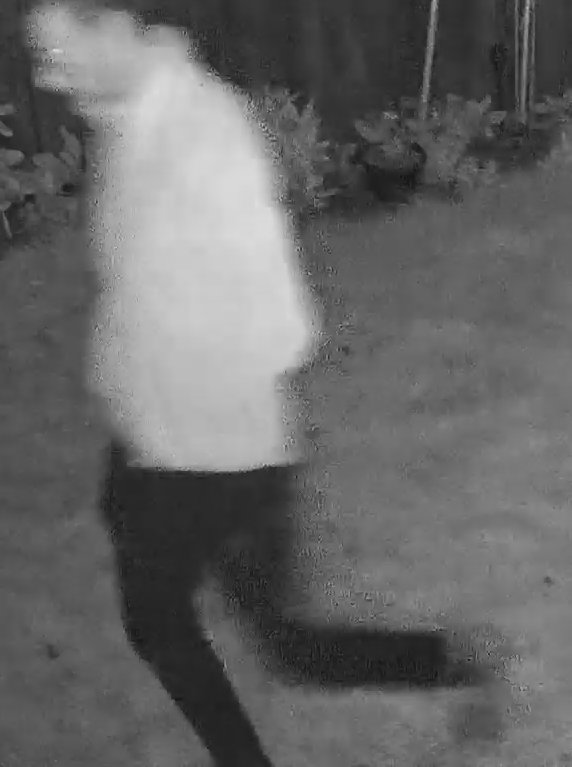

Fox: 0.003, People Sum: 0.201

--- Image being scored ---


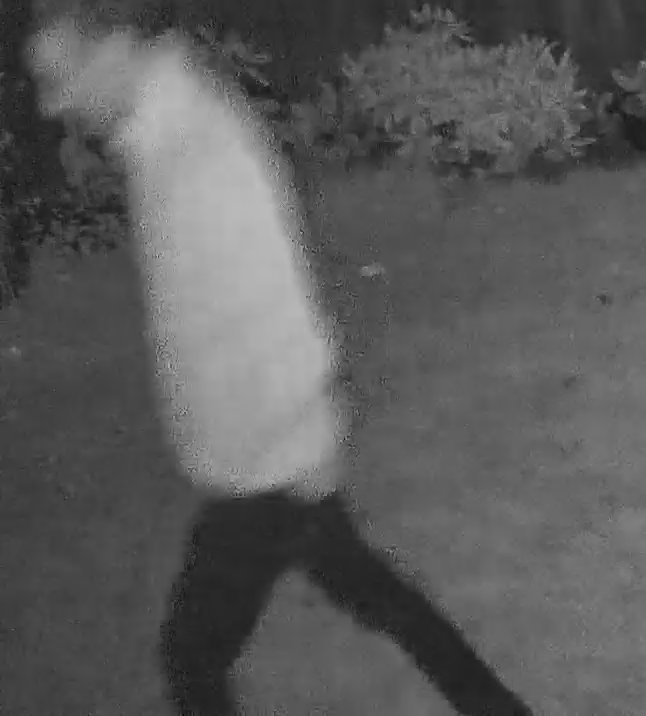

Fox: 0.014, People Sum: 0.250

--- Image being scored ---


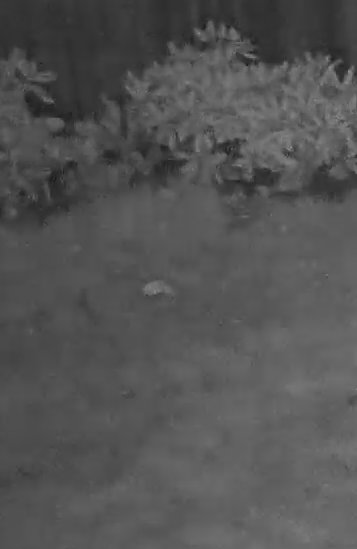

Fox: 0.038, People Sum: 0.046

--- Image being scored ---


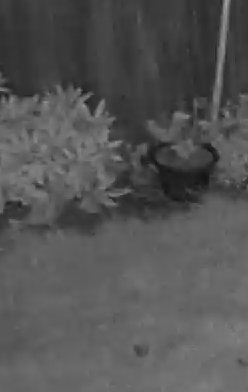

Fox: 0.060, People Sum: 0.054

--- Image being scored ---


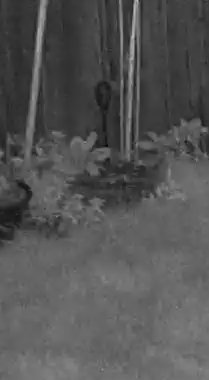

Fox: 0.041, People Sum: 0.075

--- Image being scored ---


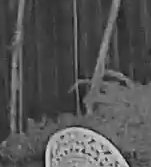

Fox: 0.039, People Sum: 0.134

--- Image being scored ---


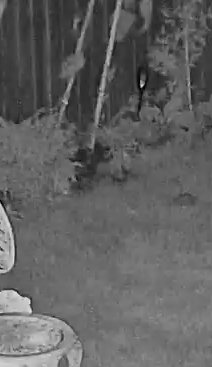

Fox: 0.055, People Sum: 0.104

--- Image being scored ---


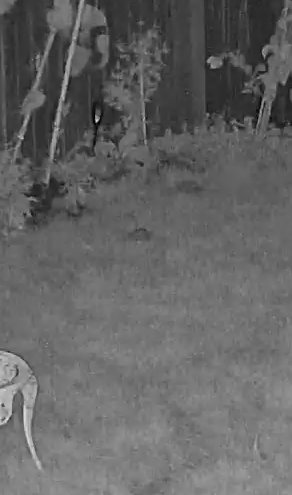

Fox: 0.185, People Sum: 0.081
New high fox score: 0.185

--- Image being scored ---


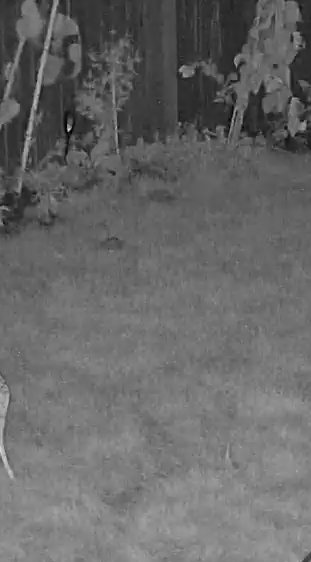

Fox: 0.104, People Sum: 0.091

--- Image being scored ---


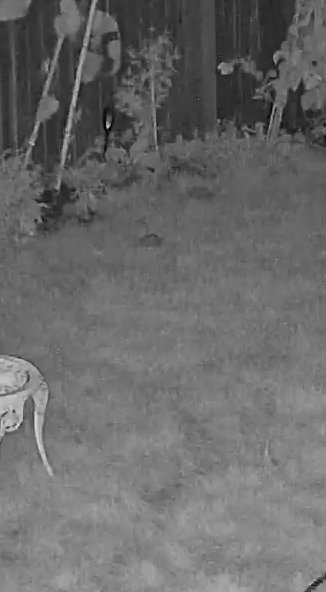

Fox: 0.139, People Sum: 0.083

--- Image being scored ---


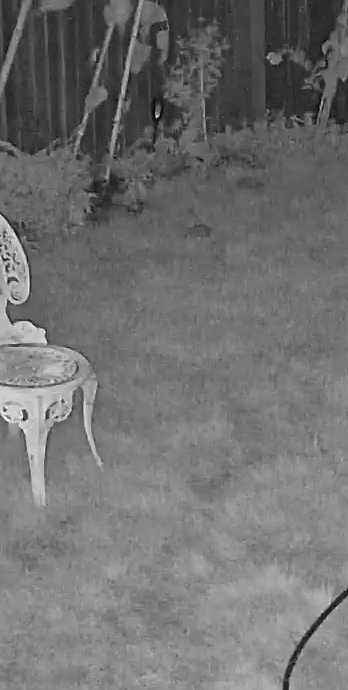

Fox: 0.005, People Sum: 0.046

--- Image being scored ---


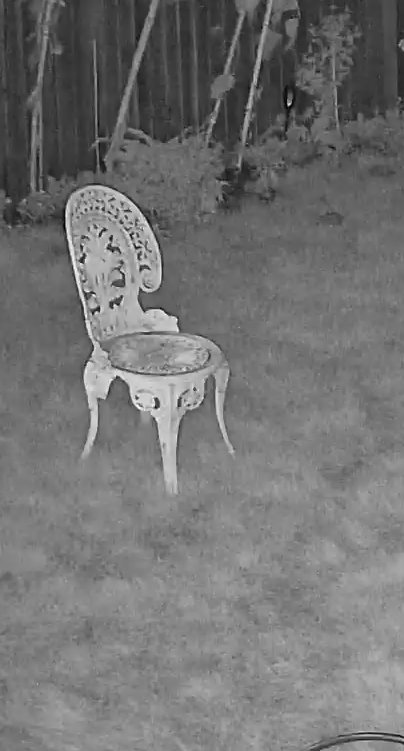

Fox: 0.000, People Sum: 0.009

--- Image being scored ---


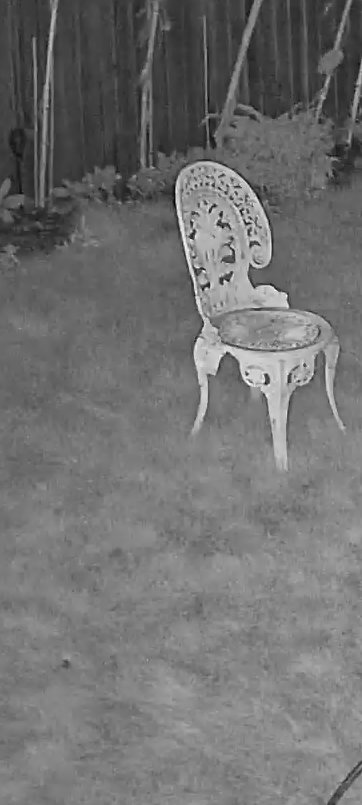

Fox: 0.001, People Sum: 0.015

--- Image being scored ---


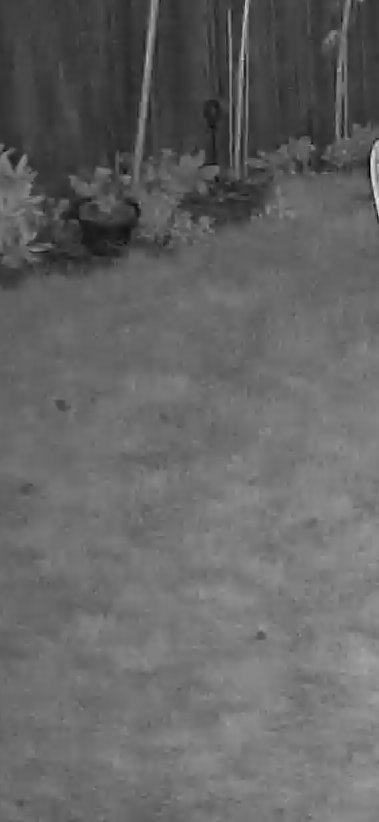

Fox: 0.030, People Sum: 0.090

--- Image being scored ---


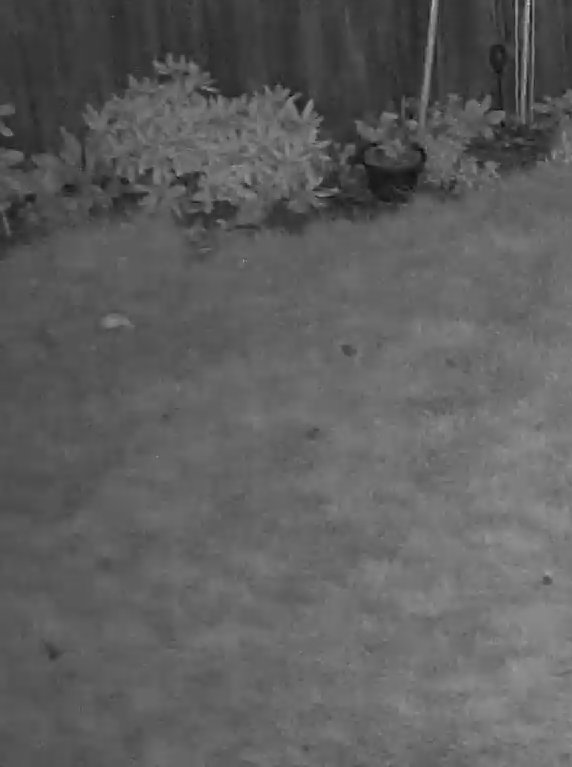

Fox: 0.047, People Sum: 0.053

--- Image being scored ---


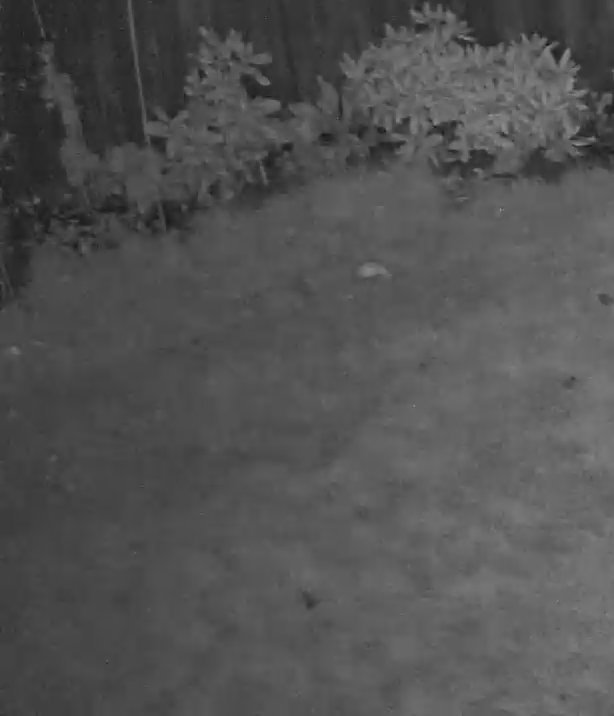

Fox: 0.034, People Sum: 0.041

--- Image being scored ---


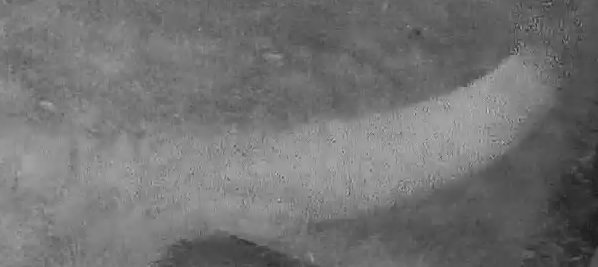

Fox: 0.010, People Sum: 0.082

--- Image being scored ---


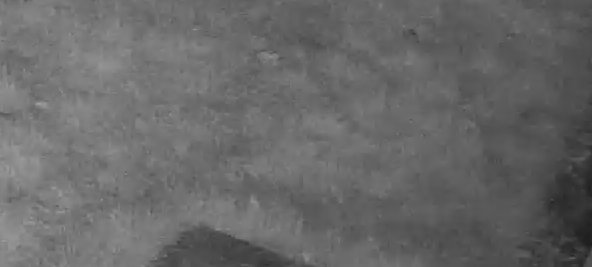

Fox: 0.010, People Sum: 0.083


In [ ]:
# ==============================================================================
# IMPORTS AND INITIAL SETUP
# ==============================================================================
import os, cv2, time, numpy as np
from collections import deque
from datetime import datetime
from IPython.display import display, Image as IPyImage
import threading
from queue import Queue
import socket
from PIL import Image
import hid
import torch
from transformers import CLIPModel, CLIPProcessor

# ==============================================================================
# RELAY & SPRINKLER CONFIG
# ==============================================================================
VENDOR_ID = 0x16c0
PRODUCT_ID = 0x05df
RELAY_TO_CONTROL = 1
RELAY_ON_COMMAND = [0x00, 0xFF, RELAY_TO_CONTROL, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00]
RELAY_OFF_COMMAND = [0x00, 0xFD, RELAY_TO_CONTROL, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00]
sprinkler_lock = threading.Lock()
max_crop_fraction = 0.15

def sprinkler_on(t=30):
    if not sprinkler_lock.acquire(blocking=False):
        print("-> Sprinkler command ignored: An operation is already in progress.")
        return
    device = None
    try:
        print(f"-> Thread started: Opening device with VID=0x{VENDOR_ID:04x} PID=0x{PRODUCT_ID:04x}")
        device = hid.device()
        device.open(VENDOR_ID, PRODUCT_ID)
        print("-> Device opened successfully.")
        print(f"-> Sending ON command to relay #{RELAY_TO_CONTROL} for {t} seconds...")
        device.send_feature_report(RELAY_ON_COMMAND)
        time.sleep(0.1)
        print("-> Relay should be ON.")
        time.sleep(t)
        print(f"-> Sending OFF command to relay #{RELAY_TO_CONTROL}...")
        device.send_feature_report(RELAY_OFF_COMMAND)
        time.sleep(0.1)
        print("-> Relay should be OFF.")
    except Exception as e:
        print(f"-> Sprinkler error: {e}")
    finally:
        if device:
            device.close()
            print("-> Device closed.")
        sprinkler_lock.release()
        print("-> Sprinkler thread finished and lock released.")

# ==============================================================================
# TINYCLIP MODEL SETUP
# ==============================================================================
# --- Configuration ---
MODEL_ID = "wkcn/TinyCLIP-ViT-39M-16-Text-19M-YFCC15M"

# --- Device Selection ---
print("Setting up AI model...")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- Load Model and Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
model.to(DEVICE)
model.eval()
print(f"Model '{MODEL_ID}' loaded and ready.")

# --- Prompts and Thresholds ---
n_people_decoys = 6
PROMPTS = [
    "man", "woman", "a person walking", "a photograph of a person",
    "people", "person wearing a jumper", "a photograph of a fox",
    "a photograph of a frog", "an empty garden at night", "a car", 'grass', 'empty', 'nothing', 'plants',
    'blurry image of nothing', 'a photograph of a cat', 'field', 'desert',
    "a blurry shadow moving on the ground", "a blurry shape moving quickly",
    "a garden chair", "photograph of a metal chair"
]
FOX_SCORE_THRESHOLD = 0.40
people_sum_thresh = 0.3

# ==============================================================================
# ✨ NEW: PRE-COMPUTE TEXT EMBEDDINGS (THE OPTIMIZATION) ✨
# ==============================================================================
print("Pre-computing text embeddings for all prompts...")
# Tokenize the prompts and move them to the selected device
text_inputs = processor(text=PROMPTS, return_tensors="pt", padding=True).to(DEVICE)

# Generate the text embeddings (features) once
with torch.no_grad():
    precomputed_text_features = model.get_text_features(**text_inputs)
    # Normalize the features for cosine similarity calculation
    precomputed_text_features /= precomputed_text_features.norm(dim=-1, keepdim=True)
print("Text embeddings are ready.")


# ==============================================================================
# NETWORKING & CAMERA SETUP
# ==============================================================================
def _check_port(ip, port, timeout=0.5):
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(timeout)
    try:
        return sock.connect_ex((ip, port)) == 0
    finally:
        sock.close()

def find_camera_ip(default_ip='192.168.68.102', subnet='192.168.68', port=554):
    if default_ip and _check_port(default_ip, port):
        print(f"✅ Success! Camera found at the last known IP: {default_ip}")
        return default_ip
    print(f"🐢 Scanning subnet {subnet}.x for a camera on port {port}...")
    for i in range(1, 255):
        ip = f"{subnet}.{i}"
        print(f"\rChecking: {ip}  ", end="")
        if _check_port(ip, port):
            print(f"\n✅ Found new camera IP at: {ip}")
            return ip
    print("\n❌ Camera not found on this subnet.")
    return None

USER = "foxyfoxy"
PASS = "foxyfoxy123"
IP = find_camera_ip(subnet='192.168.68')
if not IP:
    raise RuntimeError("Could not find camera. Exiting.")

RTSP_LOW  = f"rtsp://{USER}:{PASS}@{IP}:554/stream2"
RTSP_HIGH = f"rtsp://{USER}:{PASS}@{IP}:554/stream1"
os.environ["OPENCV_FFMPEG_CAPTURE_OPTIONS"] = "rtsp_transport;tcp|max_delay;0|threads;1"

# ==============================================================================
# UTILITIES AND HELPER CLASSES (UNCHANGED)
# ==============================================================================
# Your helper functions (ensure_dir, timestamp_str, make_mask, etc.) and
# classes (HQSampler, FileWriter) go here. They don't need to be changed.
def ensure_dir(p):
    if not os.path.isdir(p):
        os.makedirs(p, exist_ok=True)
def timestamp_str(ts=None):
    if ts is None: ts = time.time()
    return datetime.fromtimestamp(ts).strftime("%Y%m%d_%H%M%S_%f")[:-3]
USE_MASK = True
MASK_POLYGONS = [[
    (0.0, 1.0), (0.85, 1.0), (0.98, 0.4), (0.7, 0.35), (0.0, 0.57)
]]
def make_mask(shape):
    if not USE_MASK or not MASK_POLYGONS:
        return np.full(shape[:2], 255, dtype=np.uint8)
    h, w = shape[:2]
    m = np.zeros((h, w), dtype=np.uint8)
    for poly in MASK_POLYGONS:
        pts = np.array([[int(x*w), int(y*h)] for x, y in poly], dtype=np.int32)
        cv2.fillPoly(m, [pts], 255)
    return m
def grab_latest_nonblocking(cap, max_ms=8, max_grabs=60):
    t0 = time.time()
    grabs = 0
    while grabs < max_grabs:
        if not cap.grab(): break
        grabs += 1
        if (time.time() - t0) * 1000.0 >= max_ms: break
    ok, frame = cap.retrieve()
    if not ok or frame is None: ok, frame = cap.read()
    return ok, frame
def encode_jpeg(img, quality=60):
    ok, buf = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    return buf.tobytes() if ok else None
def merge_contours_to_bbox(contours, min_area=150):
    boxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > min_area]
    if not boxes: return None
    x1 = min(b[0] for b in boxes)
    y1 = min(b[1] for b in boxes)
    x2 = max(b[0] + b[2] for b in boxes)
    y2 = max(b[1] + b[3] for b in boxes)
    return (x1, y1, x2 - x1, y2 - y1)
def pad_and_clip_rect(x, y, w, h, pad_px, W, H):
    x = max(0, int(x - pad_px)); y = max(0, int(y - pad_px))
    w = int(w + 2*pad_px); h = int(h + 2*pad_px)
    x2 = min(W, x + w); y2 = min(H, y + h)
    return x, y, x2 - x, y2 - y
def choose_best_by_time(history, target_ts, max_age=None):
    best = None; best_dt = float('inf')
    for ts, f in history:
        dt = abs(ts - target_ts)
        if dt < best_dt:
            best_dt = dt; best = (ts, f)
    if best is None or (max_age is not None and best_dt > max_age):
        return None
    return best
class HQSampler:
    def __init__(self, rtsp_url):
        self.rtsp = rtsp_url
        self.cap = cv2.VideoCapture(self.rtsp, cv2.CAP_FFMPEG)
        if not self.cap.isOpened(): raise RuntimeError("Could not open HQ RTSP stream")
        try: self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        except: pass
        self.latest = (0.0, None)
        self.alive = True
        self.lock = threading.Lock()
        self.t = threading.Thread(target=self._loop, daemon=True); self.t.start()
    def _loop(self):
        while self.alive:
            ok, frame = grab_latest_nonblocking(self.cap)
            if ok and frame is not None:
                with self.lock: self.latest = (time.time(), frame)
            else:
                try: self.cap.release()
                except: pass
                time.sleep(0.1)
                self.cap = cv2.VideoCapture(self.rtsp, cv2.CAP_FFMPEG)
                try: self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
                except: pass
    def get_latest(self, max_age=1.0):
        with self.lock: ts, fr = self.latest
        if fr is None or (time.time() - ts) > max_age: return None
        return fr
    def stop(self):
        self.alive = False
        try: self.t.join(timeout=0.5)
        except: pass
        try: self.cap.release()
        except: pass
class FileWriter:
    def __init__(self, maxsize=32):
        self.q = Queue(maxsize=maxsize)
        self.t = threading.Thread(target=self._loop, daemon=True); self.t.start()
    def _loop(self):
        while True:
            item = self.q.get()
            if item is None: break
            path, img, quality = item
            try: cv2.imwrite(path, img, [int(cv2.IMWRITE_JPEG_QUALITY), int(quality)])
            except: pass
            self.q.task_done()
    def save_jpg(self, path, img, quality=82):
        try: self.q.put_nowait((path, img, quality))
        except: pass
    def stop(self):
        try: self.q.put(None)
        except: pass
        try: self.t.join(timeout=1.0)
        except: pass

# =========================
# ✨ REFACTORED AI FUNCTION ✨
# =========================

# This is the new, optimized scoring function that uses the pre-computed embeddings.
def score_frame_against_precomputed_prompts(frame, text_features):
    """
    Scores an OpenCV frame against pre-computed text embeddings.
    This is much faster as it avoids re-processing text prompts.
    """
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(rgb_frame)
    
    # Process only the image
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        # Get image features and normalize them
        image_features = model.get_image_features(**inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # Calculate similarity using matrix multiplication
        logit_scale = model.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        
        # Convert logits to probabilities
        probs = logits_per_image.softmax(dim=-1).squeeze().cpu().numpy()
        
    return probs

# =========================
# Main runner (UPDATED)
# =========================
def run_motion_view(
    precomputed_text_features, # ✨ Pass the embeddings in
    display_width=480,
    ui_fps=3,
    lookback_secs=10.0,
    save_dir="motion_events",
    jpg_quality=82,
    event_cooldown=0.5,
    post_sprinkler_cooldown=5
):
    # ... (the rest of your run_motion_view setup is the same) ...
    ensure_dir(save_dir)
    ensure_dir("sprinkler_sessions")
    highest_fox_score = 0
    cap_low = cv2.VideoCapture(RTSP_LOW, cv2.CAP_FFMPEG)
    if not cap_low.isOpened(): raise RuntimeError("Could not open LOW RTSP stream")
    try: cap_low.set(cv2.CAP_PROP_BUFFERSIZE, 1)
    except: pass
    hq = HQSampler(RTSP_HIGH)
    fw = FileWriter()
    roi_mask_low = None
    hist_len = int(max(lookback_secs * ui_fps * 2, 40))
    low_gray_history = deque(maxlen=hist_len)
    low_color_history = deque(maxlen=hist_len)
    interval = 1.0 / float(max(1, ui_fps))
    next_tick = time.time()
    sprinkler_session_dir = None
    prev_sprinkler_locked = False
    last_sprinkler_end_ts = 0.0
    last_event_ts = 0.0
    print(f"Processing at ~{ui_fps} FPS. Scoring crops on motion...")
    try:
        while True:
            now = time.time()
            if now < next_tick:
                time.sleep(max(0, next_tick - now))
                continue
            next_tick += interval

            ok_low, frame_low = grab_latest_nonblocking(cap_low)
            if not ok_low or frame_low is None:
                # Handle stream reconnect
                try: cap_low.release()
                except: pass
                time.sleep(0.1)
                cap_low = cv2.VideoCapture(RTSP_LOW, cv2.CAP_FFMPEG)
                try: cap_low.set(cv2.CAP_PROP_BUFFERSIZE, 1)
                except: pass
                continue
            
            # Resize and prep frames
            if display_width and frame_low.shape[1] > display_width:
                h = int(frame_low.shape[0] * (display_width / float(frame_low.shape[1])))
                frame_low = cv2.resize(frame_low, (display_width, h), interpolation=cv2.INTER_AREA)
            if roi_mask_low is None: roi_mask_low = make_mask(frame_low.shape)
            gray = cv2.cvtColor(frame_low, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (3,3), 0)
            gray_roi = cv2.bitwise_and(gray, gray, mask=roi_mask_low)
            low_gray_history.append((now, gray_roi.copy()))
            low_color_history.append((now, frame_low.copy()))

            # Sprinkler logic (unchanged)
            current_sprinkler_locked = sprinkler_lock.locked()
            if current_sprinkler_locked and not prev_sprinkler_locked:
                print("-> Sprinkler activated.")
            elif not current_sprinkler_locked and prev_sprinkler_locked:
                last_sprinkler_end_ts = now
                print("-> Sprinkler deactivated.")
            prev_sprinkler_locked = current_sprinkler_locked
            if current_sprinkler_locked or (now - last_sprinkler_end_ts < post_sprinkler_cooldown):
                continue
                
            # Motion detection logic (unchanged)
            ref_low_gray = choose_best_by_time(low_gray_history, now - lookback_secs)
            if ref_low_gray is None: continue
            _, ref_gray = ref_low_gray
            diff = cv2.absdiff(gray_roi, ref_gray)
            _, motion_bin = cv2.threshold(diff, 18, 255, cv2.THRESH_BINARY)
            motion_bin = cv2.morphologyEx(motion_bin, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
            motion_bin = cv2.dilate(motion_bin, None, iterations=1)
            contours, _ = cv2.findContours(motion_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            union_bbox_low = merge_contours_to_bbox(contours)
            if not union_bbox_low or (now - last_event_ts) < event_cooldown: continue
            last_event_ts = now
            
            # Cropping logic (unchanged)
            hq_now = hq.get_latest()
            if hq_now is None: continue
            x, y, w, h = union_bbox_low
            Hl, Wl = frame_low.shape[:2]; Hh, Wh = hq_now.shape[:2]
            sx, sy = Wh / float(Wl), Hh / float(Hl)
            x_hq, y_hq, w_hq, h_hq = int(x * sx), int(y * sy), int(w * sx), int(h * sy)
            pad_hq = int(0.07 * max(w_hq, h_hq)) + 8
            x_hq, y_hq, w_hq, h_hq = pad_and_clip_rect(x_hq, y_hq, w_hq, h_hq, pad_hq, Wh, Hh)
            crop_hq_now = hq_now[y_hq:y_hq+h_hq, x_hq:x_hq+w_hq]

            # ==========================================================
            # ✨ ADD THIS BLOCK TO DISPLAY THE IMAGE ✨
            # ==========================================================
            print("\n--- Image being scored ---")
            # Encode the image to JPEG format to be displayed
            data = encode_jpeg(crop_hq_now, quality=85)
            # Display the image inline in your notebook
            if data:
                display(IPyImage(data=data, width=600))
            # ==========================================================

            # ✨ --- THE CRITICAL CHANGE: USE THE OPTIMIZED FUNCTION --- ✨
            probabilities = score_frame_against_precomputed_prompts(
                crop_hq_now,
                precomputed_text_features # Pass in the pre-calculated embeddings
            )
            # ... (rest of the logic) ...

            # ✨ --- THE CRITICAL CHANGE: USE THE OPTIMIZED FUNCTION --- ✨
            probabilities = score_frame_against_precomputed_prompts(
                crop_hq_now,
                precomputed_text_features # Pass in the pre-calculated embeddings
            )

            # ... (the rest of your logic for displaying, printing scores, and triggering the sprinkler is the same)
            
            # Find the score specifically for the "fox" prompt
            fox_index = PROMPTS.index("a photograph of a fox")
            fox_score = probabilities[fox_index]
            decoys = np.sum(probabilities[:n_people_decoys])

            print(f"Fox: {fox_score:.3f}, People Sum: {decoys:.3f}")

            if fox_score > highest_fox_score:
                print(f"New high fox score: {fox_score:.3f}")
                highest_fox_score = fox_score

            if (fox_score > FOX_SCORE_THRESHOLD and decoys < people_sum_thresh):
                print(f"🦊 Fox detected with confidence {fox_score:.3f}! Triggering water valve... 💧")
                
                sprinkler_time = 5
                threading.Thread(target=sprinkler_on, args=(sprinkler_time,), daemon=True).start()
                
                ev_dir = os.path.join(save_dir, timestamp_str(now))
                ensure_dir(ev_dir)
                fw.save_jpg(os.path.join(ev_dir, f"fox_detected_{fox_score:.3f}.jpg"), crop_hq_now, jpg_quality)

    except KeyboardInterrupt:
        print("Stopped.")
    finally:
        cap_low.release()
        hq.stop()
        fw.stop()

# =========================
# ✨ Run it (UPDATED CALL) ✨
# =========================
if __name__ == '__main__':
    run_motion_view(
        precomputed_text_features=precomputed_text_features, # ✨ Pass the embeddings in
        ui_fps=2,
        lookback_secs=10.0,
        save_dir="motion_events",
        jpg_quality=82,
        event_cooldown=0.5
    )